# Part1 - Data Wrangling

### Imports

In [732]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import sys
import boto
from boto.s3.key import Key
import zipfile
import boto.s3.connection
from os.path import basename
color = sns.color_palette()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, neighbors
from sklearn.preprocessing import LabelEncoder
from uszipcode import ZipcodeSearchEngine
import matplotlib.pyplot as plt

### Importing the properties and transaction details

In [832]:
detail = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/properties_2017.csv',low_memory=False)
trans = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/train_2017.csv',low_memory=False)

#details_2017 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/properties_2017.csv',low_memory=False)
#trans_2017 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/train_2017.csv',low_memory=False)

### Getting rid of columns having more than 70% data missing

In [833]:
missing_data = detail.isnull().sum().to_frame(name='Missing_Count').reset_index()
missing_data['Missing_percent'] = (missing_data['Missing_Count']/detail.shape[0])*100
missing_data.head()
missing_data = missing_data.sort_values(by='Missing_percent', axis=0, ascending=True)
features = missing_data['index'][(missing_data.Missing_percent <30)]
detail = detail[features]

### Separating the year and month from the transactiondate column

In [834]:
trans['transactiondate'] = pd.to_datetime(trans['transactiondate'])
trans['year'] = trans['transactiondate'].dt.year
trans['month'] = trans['transactiondate'].dt.month

### Merging the data

In [835]:
df =   pd.merge(trans,detail,on='parcelid', how ='left')

### Getting rid of redudndant columns

rawcensustractandblock and censustractandblock are same meaning column->rawcensustractandblockcontains no missing data but censustractandblock columns contains missising data

In [836]:
del df['censustractandblock']

'bathroomcnt','fullbathcnt','calculatedbathnbr' are same meaning column->bathroomcnt no missing data but fullbathcnt,calculatedbathnbr columns contains missising data

In [837]:
del df['fullbathcnt']
del df['calculatedbathnbr']
del df['finishedsquarefeet12']

In [838]:
#df[['calculatedfinishedsquarefeet','finishedsquarefeet12']].isnull().sum().sort_values()

In [839]:
#df[['bathroomcnt','fullbathcnt','calculatedbathnbr']].isnull().sum().sort_values()

In [840]:
#df[['rawcensustractandblock','censustractandblock']].isnull().sum()

### Handling the latitude and longtide columns
#### Dropping latitude and longtide rows in any of them is missing
#### Correcting the latitude longitude format(decimal places)

In [841]:
df.latitude[0]

33634931.0

In [842]:
df = df.dropna(subset=['latitude'])
df = df.dropna(subset=['longitude'])

df['latitude'] = df['latitude'] / 1000000
df['longitude'] = df['longitude'] / 1000000

### Handling zipcode

In [843]:
location= ['latitude','longitude','regionidzip','regionidcity','regionidcounty']

In [844]:
df.regionidzip.describe()

count     77529.000000
mean      96586.692812
std        3793.552065
min       95982.000000
25%       96193.000000
50%       96389.000000
75%       96987.000000
max      399675.000000
Name: regionidzip, dtype: float64

In [845]:
df[['regionidzip']][df.regionidzip >= 100000].count()

regionidzip    12
dtype: int64

In [846]:
df[location][df.regionidzip >= 100000]

,latitude,longitude,regionidzip,regionidcity,regionidcounty
4702,34.145256,-117.969118,399675.0,14906.0,3101.0
7652,34.144255,-117.969104,399675.0,14906.0,3101.0
24646,34.149216,-117.969003,399675.0,14906.0,3101.0
35872,34.160173,-117.973852,399675.0,14906.0,3101.0
38690,34.144897,-117.953095,399675.0,14906.0,3101.0
42510,34.154731,-117.954681,399675.0,24435.0,3101.0
49034,34.153603,-117.953027,399675.0,24435.0,3101.0
56084,34.151260,-117.957962,399675.0,14906.0,3101.0
62845,34.145644,-117.954984,399675.0,14906.0,3101.0
69752,34.144586,-117.969104,399675.0,14906.0,3101.0


In [847]:
df[['parcelid','regionidcounty']].groupby('regionidcounty').count().sort_values(by='parcelid')

,parcelid
regionidcounty,
2061.0,6252
1286.0,20631
3101.0,50696


In [848]:
df.regionidcounty.unique()

array([ 1286.,  2061.,  3101.])

In [849]:
df[['parcelid','fips']].groupby('fips').count().sort_values(by='parcelid')

,parcelid
fips,
6111.0,6252
6059.0,20631
6037.0,50696


In [850]:
# Replacing the false zipcode with mode value of zipcode within the county group

z = df[['regionidzip','regionidcounty']][df.regionidcounty ==3101.0]
search = ZipcodeSearchEngine()
zipcode = z['regionidzip'][z.regionidzip <= 100000].mode().values[0]
df.loc[df['regionidzip'] > 100000, 'regionidzip'] = zipcode

In [851]:
# res = search.by_coordinate(34.211295,-119.027964, radius=30, returns=1)[0]['Zipcode']
# res

In [852]:
# Using ZipcodeSearchEngine to fill in the missing zipcodes

df.loc[df.regionidzip.isnull(), 'regionidzip']=search.by_coordinate(df['latitude'].values[0],df['longitude'].values[0], radius=30, returns=1)[0]['Zipcode']

### 'propertycountylandusecode'

In [853]:
#propertycountylandusecode column and it replaces all the nan with the mode of the column
df['propertycountylandusecode'] = df['propertycountylandusecode'].apply(lambda x: np.nan if x == 0 else x) 
#and type(x) is not object else x)    # for a column in train_df, change any zero values to Nan
df['propertycountylandusecode'] = df['propertycountylandusecode'].fillna(df['propertycountylandusecode'].mode()[0]) 
#fill Nan values with mode values

In [854]:
lb_make = LabelEncoder()
df["propertycountylandusecode"] = lb_make.fit_transform(df["propertycountylandusecode"])
df[["propertycountylandusecode"]]
lb_makeDesc = LabelEncoder()
lb_makeDesc = LabelEncoder()
df["transactiondate"] = lb_makeDesc.fit_transform(df["transactiondate"])

### taxvaluedollarcnt

In [855]:
df['taxvaluedollarcnt'].fillna(df['taxvaluedollarcnt'].median(), inplace=True)

### landtaxvaluedollarcnt

In [856]:
df['landtaxvaluedollarcnt'].fillna(df['landtaxvaluedollarcnt'].median(), inplace=True)

### taxamount

In [857]:
df['taxamount'].fillna(df['taxamount'].median(), inplace=True)

### yearbuilt

In [858]:
def knn_year(yeardf):
    whole = ['latitude','longitude','yearbuilt','parcelid']
    base = ['latitude','longitude']
    target_column = 'yearbuilt'

    null = yeardf[target_column].isnull()
    not_null = ~null
    num_miss = null.sum()
    if num_miss ==0:
        print('No Null Values!!!')
    else:
        X_train = yeardf.loc[not_null, whole].sample(frac = 1)

        # X_train.latitude.astype(int)
        # X_train.longitude.astype(int)
        # X_train.yearbuilt.astype(int)
        X=X_train[base].values

        y = X_train[target_column].astype(int)
        y = y.values

        Y_target =yeardf.loc[null, whole].sample(frac = 1)
        Y_target.latitude.astype(int)
        Y_target.longitude.astype(int)

        Y =Y_target[['latitude','longitude']].values

        clf = neighbors.KNeighborsClassifier()
        clf.fit(X,y)
        accuracy = clf.score(X, y)
        print(accuracy) 

        #Y = Y.reshape(len(X), -1)
        prediction = clf.predict(Y)
        Y_target.loc[Y_target.yearbuilt.isnull(),'yearbuilt'] = prediction
        yeardf.loc[yeardf.parcelid.isin(Y_target.parcelid), ['yearbuilt']] = Y_target[['yearbuilt']]

In [859]:
knn_year(df)

0.574460929517


### Adding the 'age' column

In [860]:
df['age'] =2017-df['yearbuilt']

### Dealing with missing calculatedfinishedsquarefeet data

In [861]:
df.calculatedfinishedsquarefeet.describe()

count    77378.000000
mean      1784.935421
std        954.250373
min        128.000000
25%       1182.000000
50%       1542.000000
75%       2112.000000
max      35640.000000
Name: calculatedfinishedsquarefeet, dtype: float64

In [862]:
df[df['calculatedfinishedsquarefeet']< 1773].shape

(48374, 26)

In [863]:
df[df['calculatedfinishedsquarefeet']>=120].shape

(77378, 26)

In [864]:
df.calculatedfinishedsquarefeet.isnull().sum()

201

In [865]:
# Getting rid of the outliers

df = df[df.calculatedfinishedsquarefeet>=120]

### structuretaxvaluedollarcnt

In [866]:
df.structuretaxvaluedollarcnt.isnull().sum()

97

In [867]:
df.structuretaxvaluedollarcnt.describe()

count    7.728100e+04
mean     1.886669e+05
std      2.276902e+05
min      4.400000e+01
25%      8.425700e+04
50%      1.364020e+05
75%      2.184210e+05
max      1.142179e+07
Name: structuretaxvaluedollarcnt, dtype: float64

In [868]:
df['structuretaxvaluedollarcnt'].fillna(df['structuretaxvaluedollarcnt'].median(), inplace=True)

In [869]:
df.isnull().sum().sort_values()

parcelid                           0
landtaxvaluedollarcnt              0
yearbuilt                          0
structuretaxvaluedollarcnt         0
calculatedfinishedsquarefeet       0
taxvaluedollarcnt                  0
taxamount                          0
regionidzip                        0
propertycountylandusecode          0
roomcnt                            0
bathroomcnt                        0
bedroomcnt                         0
latitude                           0
longitude                          0
regionidcounty                     0
rawcensustractandblock             0
propertylandusetypeid              0
fips                               0
month                              0
year                               0
transactiondate                    0
logerror                           0
assessmentyear                     0
age                                0
regionidcity                    1460
lotsizesquarefeet               8174
dtype: int64

### lotsizesquarefeet

In [870]:
df.lotsizesquarefeet.describe()

count    6.920400e+04
mean     2.990261e+04
std      1.230590e+05
min      2.360000e+02
25%      5.700000e+03
50%      7.205000e+03
75%      1.181675e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64

In [871]:
df['lotsizesquarefeet'][df.lotsizesquarefeet>=3000000]

4215     6971010.0
8238     3589145.0
10779    3589145.0
13761    6971010.0
16676    6971010.0
21877    3589145.0
26758    3589145.0
27940    6971010.0
30341    6971010.0
37109    3589145.0
53823    6971010.0
56566    3589145.0
60833    3589145.0
65495    3589145.0
66935    6971010.0
74636    3589145.0
Name: lotsizesquarefeet, dtype: float64

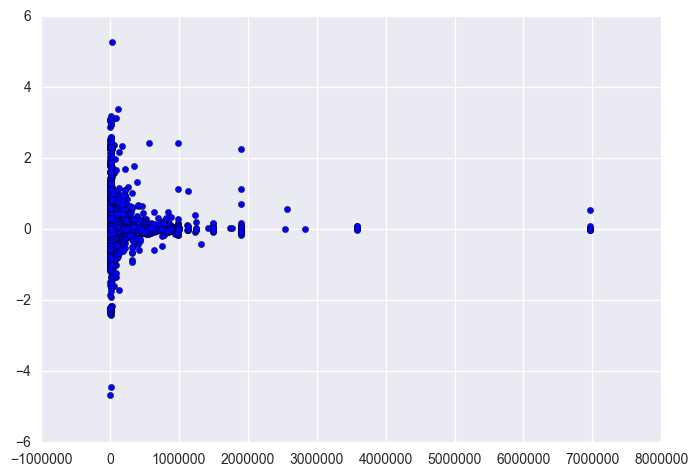

In [872]:
plt.scatter(df['lotsizesquarefeet'],df['logerror'])
plt.show()

In [873]:
# Handling outliers
lot_median =df['lotsizesquarefeet'].median()

In [874]:
df.loc[df.lotsizesquarefeet > 2000000, 'lotsizesquarefeet']= lot_median
df['lotsizesquarefeet'].fillna(df['lotsizesquarefeet'].median(), inplace=True)

### Regionidcity

In [875]:
df[['parcelid','regionidcounty','regionidcity']].groupby('regionidcounty').count().sort_values(by='parcelid')

,parcelid,regionidcity
regionidcounty,,
2061.0,6230,6216
1286.0,20522,20128
3101.0,50626,49574


In [876]:
def missingcity(m):
    city = m[['regionidcounty','parcelid', 'regionidcity']]
    Mode = m['regionidcity'].mode()[0]
    county= list(city['regionidcounty'].unique())

    for c in county:
        temp = city[city.regionidcounty == c]
        if(temp.shape == temp[temp.isnull().any(axis=1)].shape ):
                temp['regionidcity'].fillna(Mode, inplace=True)
        else:
                c = temp['regionidcity'].mode()[0]
                temp['regionidcity'].fillna(c, inplace=True)
        city.loc[city.parcelid.isin(temp.parcelid), ['regionidcity']] = temp[['regionidcity']]
    city['regionidcity'].fillna(city['regionidcity'].mode()[0], inplace = True)      
    m.loc[m.parcelid.isin(city.parcelid), ['regionidcity']] = city[['regionidcity']]

In [877]:
missingcity(df)

/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/sonalichaudhari/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Uploading csv to AWS

In [37]:
AWS_ACCESS_KEY_ID=''
AWS_SECRET_ACCESS_KEY=''
try:
    connect = boto.connect_s3(AWS_ACCESS_KEY_ID,AWS_SECRET_ACCESS_KEY)

except:
    print("incorrect aws access key and/or secret key")

In [879]:
# #connection = boto.connect_s3(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

# #csvFile = 'zillowData.csv'
# zipname = "zillowdata.zip"
# z = zipfile.ZipFile(zipname, "w")
# z.write('zillowData.csv')
# cur_path
# bucket_name = 'zillowdatampsc'



# loc = boto.s3.connection.Location.USWest

# bucket = connect.create_bucket(bucket_name, location=loc)
# def percent_cb(complete, total):
#     sys.stdout.write('.')
#     sys.stdout.flush()

# s3key = boto.s3.key.Key(bucket)
# s3key.key = zipname
# s3key.set_contents_from_filename(zipname, cb=percent_cb, num_cb=10)

In [888]:
df.isnull().sum()

parcelid                        0
logerror                        0
transactiondate                 0
year                            0
month                           0
fips                            0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcounty                  0
longitude                       0
latitude                        0
assessmentyear                  0
bedroomcnt                      0
bathroomcnt                     0
roomcnt                         0
propertycountylandusecode       0
regionidzip                     0
taxamount                       0
taxvaluedollarcnt               0
calculatedfinishedsquarefeet    0
structuretaxvaluedollarcnt      0
yearbuilt                       0
landtaxvaluedollarcnt           0
regionidcity                    0
lotsizesquarefeet               0
age                             0
dtype: int64

### Coverting to csv

In [899]:
# df.to_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/Clean_2016.csv', sep=',')
df.to_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/Clean_2017.csv', sep=',')
#df

In [900]:
df2016 = pd.read_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/Clean_2016.csv',low_memory=False)
del df2016['Unnamed: 0']

In [893]:
#del df_concat['index']
#df2016

In [901]:
df_concat = pd.concat([df2016, df]).reset_index()
del df_concat['index']

In [904]:
df_concat.shape

(166989, 26)

In [905]:
df2016.shape

(89611, 26)

In [906]:
df_concat.to_csv('/Users/sonalichaudhari/Desktop/ADS_MidTerm/Data/New_Data/Clean_Combined.csv', sep=',')

